# SDSS Tutorial #3:  Galaxy Morphologies

[Prof. Britt Lundgren, University of North Carolina Asheville](https://astrophysics.wp.unca.edu/britt-lundgren/)



## Objective
 - Using Sloan Digital Sky Survey (SDSS) data and crowd-sourced Galaxy Zoo classifications to explore the morphological types of galaxies in the local Universe.

## Learning Outcomes

By the end of this notebook, you should be able to: 
 - Navigate and query the Galaxy Zoo dataset, to select galaxies based on their shape
 - Explore how galaxy morphology correlates with color and magnitude
 - Interrogate the Galaxy Zoo dataset for evidence of human bias in the classifications
 

## Prerequisites

* This notebook assumes that the user has basic proficiency in the **Python** programming language.
* This notebook uses **SQL queries** to select data from the SDSS database. If the SQL language and/or the SDSS database is new to you, we recommend this [brief tutorial](http://cas.sdss.org/dr16/en/help/howto/search/searchhowtohome.aspx). 
* This notebook is intended to be run in the [SciServer Compute](http://www.sciserver.org/tools/compute/) platform. If you have not used SciServer before, please review the [first notebook](https://escip.io/notebooks/sdss_tutorial_1.html) in this series of activities. 

Before we begin, let's fetch some required files:

In [5]:
# Import required images for this notebook

import os

if not os.path.exists('img'):
    !mkdir img
    
imgs = ['TuningFork.jpeg','Willet1.png','WilletT2.png']
for i in imgs:
    if not os.path.exists('img/'+i):
        os.system('wget --no-check-certificate --content-disposition https://github.com/brittlundgren/ASTR420/raw/update_2023/img/'+i)
        os.system('mv %s img/' % i)
        
print('images imported')

images imported


**NOTE: In order for embedded images to display properly in this notebook, it may be necessary to restart the kernel and reopen this notebook before continuing. Do not re-compile the cell above after restarting.**


## Introduction

The Hubble system of galaxy morphological classification is illustrated in the well-known tuning-fork diagram, published in his 1936 book "The Realm of the Nebulae".  This has often been misinterpreted as a diagram for galaxy evolution, but it was really only ever intended for classification purposes. As we will find out later, galaxy evolution is a much more complicated process than what might be naively assumed from the historical terminology of "early-type" (elliptical) and "late-type" (spiral) galaxies. 

![TuningFork](img/TuningFork.jpeg)

With the advent of the vast Sloan Digital Sky Survey, which has imaged one quarter of the night sky, we now have detailed images of hundreds of thousands of galaxies in the local universe.  The SDSS DR8 also includes data on visual galaxy morphologies from the 
 [Galaxy Zoo](https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/) project. Galaxy Zoo is a web-based project
 that used the collective efforts of about 100,000 volunteer 
 citizen scientists to classify more than one million
 SDSS DR7 Main Galaxy Sample (MGS) galaxies.
 Full details on the classification process, including the operation
 of the site and estimates of classification accurary, are given in
 [Lintott et al. (2008)](http://adsabs.harvard.edu/abs/2008MNRAS.389.1179L).
 
 Today we'll use SDSS data and GalaxyZoo morphological classifications to explore how various properties of galaxies like color, shape, and magnitude are related. 
 
 Let's start, as always, by importing all of the most important libraries that we're likely to need...

In [40]:
# Import Python libraries to work with SciServer (see http://www.sciserver.org/docs/sciscript-python/)

import SciServer.CasJobs as CasJobs # query with CasJobs, the primary database for the SDSS
import SciServer.SkyServer as SkyServer # show individual objects through SkyServer
import SciServer.SciDrive           # read/write to/from SciDrive, cloud-based storage for your work
import numpy as np                  # standard Python library for math operations
import pandas                       # package for structuring and visualizing data
import matplotlib.pyplot as plt     # package for graphing and visualization 
print('SciServer libraries imported')

# Apply some special settings to the imported libraries

# ensures columns get written completely in notebook
pandas.set_option('display.max_colwidth', -1)
# do *not* show python warnings 
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, Image, SVG, Math
print('Settings applied')

# So that we're able to make plots, import matplotlib and some of its modules

import matplotlib
%config InlineBackend.rc = {}
from matplotlib import pylab as plt
%matplotlib inline
print('OK')


SciServer libraries imported
Settings applied
OK


 ------------------------
 ## Exploring Morphological Trends with GalaxyZoo

Galaxy Zoo data are contained in tables that begin with "zoo"
in the [SDSS Table schema](https://skyserver.sdss.org/dr15/en/help/browser/browser.aspx#&&history=search+zoo). For each galaxy, available data includes its
SDSS object ID and weighted probabilities for each of six different
morphological classifications based on counts of volunteer "votes".
Full details on what data the Galaxy Zoo catalog contains are given
in [Lintott et al. (2010)](http://adsabs.harvard.edu/abs/2011MNRAS.410..166L).

While familiarizing yourself with the Galaxy Zoo data it may be helpful to review a description of the method used to collect the data in the GalaxyZoo 2 data table, from [Willet et al. 2013](http://adsabs.harvard.edu/cgi-bin/nph-data_query?bibcode=2013MNRAS.435.2835W&link_type=ARTICLE&db_key=AST&high=).  A flowchart of the questions used to determine morphological characteristics is shown below.
![GalaxyZoo2](img/Willet1.png)


The simplest Galaxy Zoo table [(ZooNoSpec)](https://skyserver.sdss.org/dr16/en/help/browser/browser.aspx#&&history=description+zooNoSpec+U) can be queried to deliver the weighted probability that a given galaxy has each of the following six morphological classifications:

elliptical: 'p_el'

spiral (clockwise winding):  'p_cw' 

spiral (counter-clockwise winding): 'p_acw' 

edge-on: 'p_edge'

merger: 'p_mg'

undetermined: 'p_dk'


In [41]:
# Here's an example query to return information for 
# 100 galaxies that have spectra, clean photometry,
# at least 10 Galaxy Zoo volunteer votes, and at least an 80% probability
# of being clockwise spirals.

query="""
SELECT TOP 100 p.objid, p.ra,p.dec,p.petror90_r, p.dered_g as g, p.dered_r as r, s.z as z_spec, s.zErr, zns.nvote, zns.p_el as elliptical, zns.p_cw as spiralclock, zns.p_acw as spiralanticlock, zns.p_edge as edgeon, zns.p_dk as dontknow, zns.p_mg as merger
  FROM Galaxy as p
   JOIN ZooNoSpec AS zns ON p.objid = zns.objid
   JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE p.clean=1 and zns.nvote >= 10 and zns.p_cw > 0.8
"""
cw_spiral_gals = CasJobs.executeQuery(query, "dr16")
cw_spiral = cw_spiral_gals.set_index('objid')
cw_spiral

,ra,dec,petror90_r,g,r,z_spec,zErr,nvote,elliptical,spiralclock,spiralanticlock,edgeon,dontknow,merger
objid,,,,,,,,,,,,,,
1237655560403354055,248.120390,-0.478861,7.999845,16.81796,16.09974,0.070390,0.000023,40,0.075,0.800,0.000,0.100,0.000,0.025
1237655550206804790,247.424991,-0.167082,8.663761,17.34978,16.86310,0.044132,0.000015,52,0.038,0.808,0.019,0.058,0.019,0.058
1237655550742298700,244.181495,0.246477,33.808320,14.30792,13.43907,0.030653,0.000008,27,0.000,0.963,0.037,0.000,0.000,0.000
1237655550742495634,244.634505,0.247022,7.150454,17.32471,16.87982,0.069048,0.000006,69,0.072,0.884,0.000,0.014,0.014,0.014
1237655693557498228,237.267896,-0.673175,9.216278,16.12807,15.53160,0.077081,0.000006,27,0.000,1.000,0.000,0.000,0.000,0.000
1237654668666994779,161.716898,-1.205757,10.133840,16.18327,15.62189,0.067562,0.000017,25,0.080,0.880,0.000,0.040,0.000,0.000
1237654668663455984,153.620585,-1.231106,13.819370,15.95887,15.30673,0.058306,0.000020,19,0.000,0.947,0.053,0.000,0.000,0.000
1237654668663521537,153.865958,-1.203912,10.472660,16.74140,16.17173,0.061621,0.000021,51,0.078,0.824,0.020,0.078,0.000,0.000
1237651540316586091,149.772232,64.470694,8.702432,17.21762,16.25781,0.117470,0.000018,55,0.000,1.000,0.000,0.000,0.000,0.000


**YOUR TURN:  In the cell below, write a search of the [zoo2MainSpecz](https://skyserver.sdss.org/dr12/en/help/browser/browser.aspx#&&history=description+zoo2MainSpecz+U) Table to retrieve samples for each of the three major types of galaxies in the Hubble's "Tuning Fork" diagram (elliptical, spiral, and barred spiral).** You might find it helpful to start by modifying the query below, which selects non-barred spiral galaxies from the zoo2MainSpecz table.


In [53]:
# Example query to find non-barred spirals:
#
# Selects Galaxy Zoo galaxies with spectra, with redshifts in the range 0.1<z<0.12;
# clean photometry, with de-reddened g and r magnitudes with signal to noise greater than 10;
# at least 10 votes, where >=80% of reliable voters said there was no bar visible;
# and flagged as spirals

query="""
SELECT TOP 500 p.objid, p.ra,p.dec,p.petror90_r, p.dered_g as g, p.dered_r as r, s.z as z_spec, s.zErr
  FROM Galaxy as p
   JOIN zoo2MainSpecz AS zms ON p.objid = zms.dr8objid
   JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE p.clean=1 AND zms.total_votes >= 10 AND zms.t03_bar_a07_no_bar_weighted_fraction > 0.8 AND 
    zms.t04_spiral_a08_spiral_flag =1 AND p.dered_g/p.err_g > 10 AND p.dered_r/p.err_r > 10 AND s.z BETWEEN 0.1 and 0.12
"""
spiral_gals = CasJobs.executeQuery(query, "dr16")
spirals = spiral_gals.set_index('objid')

# Copy the query above twice in the space below, and modify it to create two more tables: 
# one containing only ellipticals, and one containing only barred spirals
#
# Note: It may be helpful to name those tables something like "ellipticals" and "barred"
# to distinguish them from the "spirals" table that was just created

# YOUR CODE HERE

**Measure and print the mean g-r color for a large sample of each type (elliptical, spiral, barred spiral).** You might find it helpful to modify the color calculation copied below for the example of non-barred spirals.

In [54]:
# calculate the g-r color for clockwise spirals
color_spiral = spirals['g']-spirals['r']

# calculate the mean color
mean_color_spiral = np.mean(color_spiral)

# print the results
print('Average g-r:\n')
print('Non-barred Spirals: ' + str(np.round(mean_color_spiral,2)))

# Now do the same for the ellipticals and barred spirals
# YOUR CODE HERE




Average g-r:

Non-barred Spirals: 0.71


**In the cell below, create a plot comparing histograms of the color distributions of each of the three major galaxy types: elliptical, spiral, and barred spiral.**

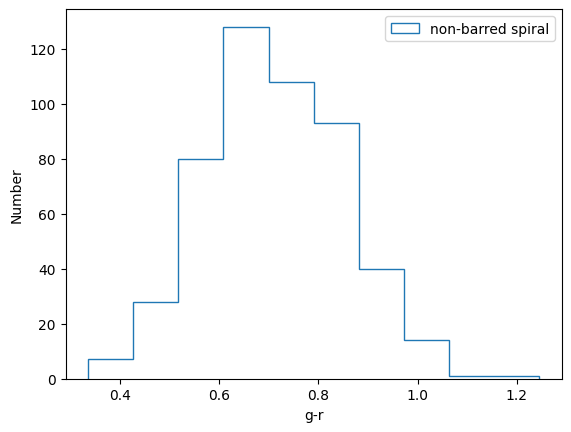

In [58]:
# To get you started, here is a histogram of g-r color for non-barred spiral galaxies
plt.hist(color_spiral, histtype='step', label = 'non-barred spiral')
plt.xlabel('g-r')
plt.ylabel('Number')
plt.legend()
plt.show()

# YOUR CODE HERE

**Describe your findings in the cell below.** 

Your interpretation here.

----------------------
## Adding morphological information to the Galaxy Color-Magnitude Diagram

In a previous notebook you constructed your own [galaxy color-magnitude diagram](https://en.wikipedia.org/wiki/Galaxy_color%E2%80%93magnitude_diagram) (e.g., g vs. g-r).  By selecting a sample of galaxies with high signal-to-noise (e.g., g/gErr > 10) and a small redshift range (e.g., 0.1<z<0.12), you should have been able to resolve what is known as the "red sequence" and the "blue cloud".  GalaxyZoo provides us with the information to now look for morphological trends in that diagram.

**Use your queried Galaxy Zoo tables to explore where on the color-magnitude diagram galaxies of different Hubble "types" are preferentially found.**
(One way to do this is to create a color-magnitude diagram with each type of galaxy overplotted with a different maker type or color in the same figure.)

In [ ]:
# YOUR CODE HERE

**Describe your findings in the cell below.**

**Interpretation:** There is a definite morphology-dependence in the color-magnitude diagram. Elliptical galaxies mostly occupy the narrow "red sequence" region but also have some membership in the "blue cloud". Both spiral and barred spiral galaxies are commonly found in the blue cloud, and some can be found in the red sequence as well.  The barred spiral galaxies appear to be the most common type within the "green valley".

-------------
## Exploring the "Green Valley"

**Modify the code below to select and display images for only the galaxies that fall in between the "red sequence" and the "blue cloud".**  

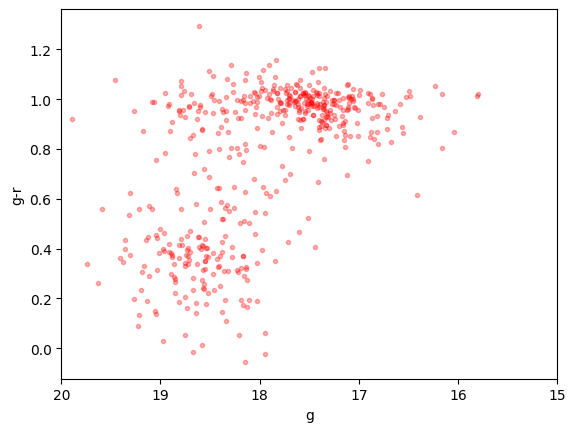

Getting image 1 of 500...
Getting image 2 of 500...
Getting image 3 of 500...
Getting image 4 of 500...
Getting image 5 of 500...
Getting image 6 of 500...
Getting image 7 of 500...
Getting image 8 of 500...
Getting image 9 of 500...
Getting image 10 of 500...
Getting image 11 of 500...
Getting image 12 of 500...
Getting image 13 of 500...
Getting image 14 of 500...
Getting image 15 of 500...
Getting image 16 of 500...


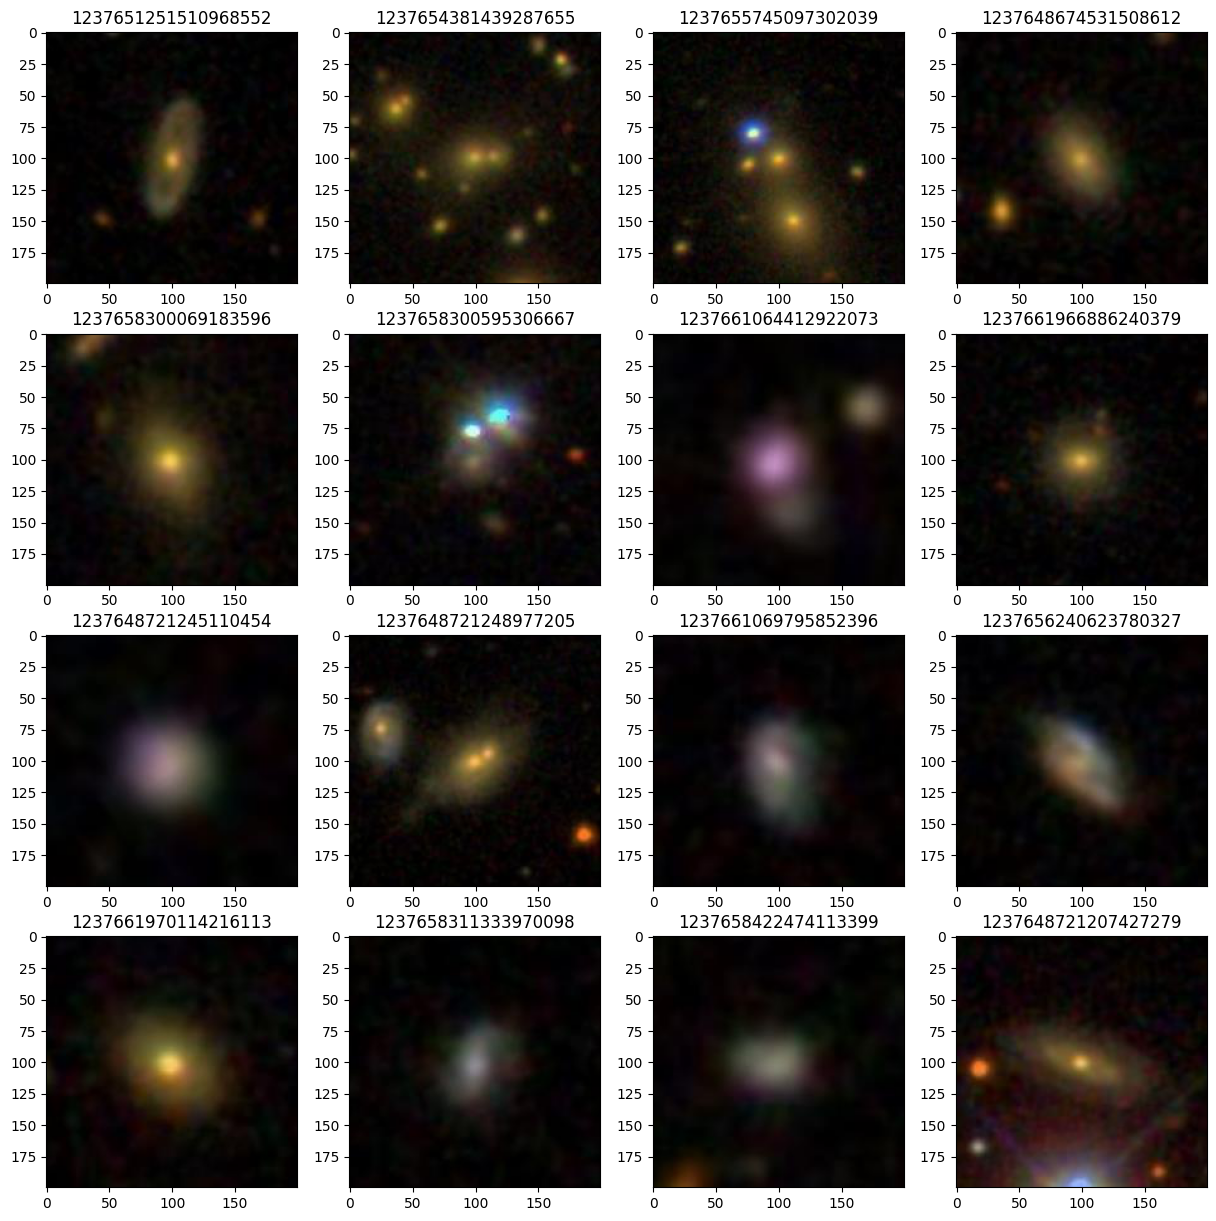

In [57]:
query="""
SELECT TOP 500 p.objid, p.ra,p.dec,p.petror90_r, p.dered_g as g, p.dered_r as r, s.z as z_spec, s.zErr
  FROM Galaxy as p
   JOIN ZooNoSpec AS zns ON p.objid = zns.objid
   JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE p.clean=1 AND p.dered_g/p.err_g > 10 AND p.dered_r/p.err_r > 10 AND s.z BETWEEN 0.1 and 0.12
"""
gval = CasJobs.executeQuery(query, "dr16")
gval = gval.set_index('objid')

gmr=gval['g']-gval['r']

# display the color magnitude diagram
plt.scatter(gval['g'],gmr,c='r',alpha=0.3,marker='.')
plt.xlabel('g')
plt.ylabel('g-r')
plt.xlim(20,15)
plt.show()

# set thumbnail parameters
width=200           # image width
height=200          # height
pixelsize=0.396     # image scale
plt.figure(figsize=(15, 15))   # display in a 4x4 grid
subPlotNum = 1

i = 0
nGalaxies = len(gval)  # I changed the name of my retrieved data to 'gals_lowv', so I've edited this line (and the next) to match
for index,gal in gval.iterrows():         
    i = i + 1
    if i<17:
        print('Getting image '+str(i)+' of '+str(nGalaxies)+'...')
        if (i == nGalaxies):
            print('Plotting images...')
        scale=2*gal['petror90_r']/pixelsize/width
        img= SciServer.SkyServer.getJpegImgCutout(ra=gal['ra'], dec=gal['dec'], width=width, height=height, scale=scale,dataRelease='DR16')
        plt.subplot(4,4,subPlotNum)
        subPlotNum += 1
        plt.imshow(img)                               # show images in grid
        plt.title(index)                              # show the object identifier (objId) above the image.

**Do you find any trends in their morphologies?** Describe your findings in the cell below.

Your interpretation here.

------------------------
## Exploring potential bias in GalaxyZoo data, Part 1

GalaxyZoo works because people are naturally amazing at pattern recognition, even for difficult shapes like spirals, which have historically challenged artificial intelligence.  But our ability to quickly detect patterns can also mean that we are suceptable to bias.

Let's try a couple of quick tests:

**First, what fraction of the spirals are identified in GalaxyZoo as "clockwise", compared to "counter-clockwise"?**



In [39]:
# YOUR CODE HERE

**Discuss your findings in the cell below:**

Your interpretation here.

Note: GalaxyZoo scientists have done extensive testing on this question about how human pattern recognition may be better or worse when observing spirals that wind in a particular direction.   The data for results from their tests can be quereied from the [zooMirrorBias](http://skyserver.sdss.org/dr15/en/help/browser/browser.aspx#&&history=description+zooMirrorBias+U) table.

------------------------
## Exploring potential bias in GalaxyZoo data, Part 2

Next, does the color distribution of "spirals" and "ellipticals" appear any different if the results are obtained by only showing users monochromatic (i.e., black and white) images?  

Explore this question by querying the SDSS table [zooMonochromeBias](https://skyserver.sdss.org/dr12/en/help/browser/browser.aspx#&&history=description+zooMonochromeBias+U), which contains GalaxyZoo results from monochrome images. 
**Select samples of spirals and ellipticals in the redshift range 0.05 to 0.07 from the Galaxy Zoo monochrome data table and overplot the distributions of each sample on a color-magnitude diagram.**

In [ ]:
# YOUR CODE HERE

**How does the color-magnitude distribution compare to samples of ellipticals and spirals selected from the GalaxyZoo full color dataset, which you plotted earlier?** Discuss your findings in the cell below:

Your interpretation here.